# AiDM assignment 1
## Recommender system --- Matrix factorization 

## Read data
We load the ratings data into a matrix which has 4 columns. The first column gives the user id. The second column gives the movie id. The third column gives the rating which can only be a integer from 1 to 5. The fourth column gives the timestamp in a unit of second.

In [2]:
import numpy as np
data_all = np.genfromtxt('ml-1m/ratings.dat', delimiter= '::')

## Gradient descent
Next we create a list containing the unique user and movie ids, as well as a vector of 20 weights for each. We will train the network so that the dot product of a given user vector with a movie vector will be a prediction of the user's rating for that movie. In this way, the weights of a movie might reflect certain qualities whereas the weights of a user might reflect which qualities that particular user prefers.

In [49]:
def training(data, length, lrate, lamb, Iterations):

    '''
    we create a list containing the unique user and movie ids, as well as a vector of 20 weights for each. 
    We will train the network so that the dot product of a given user vector with a movie vector 
    will be a prediction of the user's rating for that movie. 
    In this way, the weights of a movie might reflect certain qualities 
    whereas the weights of a user might reflect which qualities that particular user prefers.
    '''
    user_list = np.unique(data[:,0])
    movie_list = np.unique(data[:,1])
    user_vector = np.random.uniform(size=(len(user_list),length))
    movie_vector = np.random.uniform(size=(len(movie_list),length))
    
    '''
    Next we create vectors of the indicies for the weights vectors for the users and movies 
    in the original data from ratings.dat. 
    This is important since weight vectors for *unique* movies is not the same as the movie id, 
    since there some movies which have not been rated in the data and it would be unhelpful to have random, 
    unconstrained wieght vectors for movies not rated in the data.
    '''
    user_locator = np.zeros(len(data))
    movie_locator = np.zeros(len(data))

    for i in range(len(data)):
        user_locator[i] = np.where(user_list==data[i,0])[0][0]
        movie_locator[i] = np.where(movie_list==data[i,1])[0][0]
    #There are some unrated movies.
    '''
    Next we train the weight vectors! Note that we force predictions to be between 1 and 5, 
    and include a lambda regularization factor to counteract overfitting with large weights.
    '''
    total_error = np.zeros(iterations)
    for count in range(iterations):
        for i in range(len(data)):
            est_rating = np.dot(user_vector[int(user_locator[i])],movie_vector[int(movie_locator[i])])
            if est_rating < 1 :
                est_rating = 1
            if est_rating > 5 :
                est_rating = 5
            error = data[i,2] - est_rating
            user_vector[int(user_locator[i])]  += \
            lrate * (error * movie_vector[int(movie_locator[i])] - lamb *  user_vector[int(user_locator[i])])
            movie_vector[int(movie_locator[i])] += \
            lrate * (error * user_vector[int(user_locator[i])] - lamb * movie_vector[int(movie_locator[i])])
            total_error[count] += abs(error)
        count += 1
    return total_error, user_list, user_vector, movie_list, movie_vector

Now that we have trained our network, let's take a look at how it predicts a few random entries.

In [52]:
for i in np.random.randint(len(data), size=10):
    print(i, np.dot(user_vector[int(user_locator[i])],movie_vector[int(movie_locator[i])]), data[i,2], )

710227 2.81779780378738 4.0
758447 2.627678295466427 2.0
517077 2.868219260277941 2.0
670142 3.1157056714354145 1.0
805293 3.3205360072996277 4.0
157314 3.4568220108502894 4.0
925642 3.7368261511998373 4.0
288100 2.197447691463461 2.0
261156 3.6510271263009435 5.0
387689 3.331272438761476 4.0


Not bad! Now lets see how the error changes over the course of fitting.

Text(0, 0.5, 'Error Relative to Initial Error with Random Weights (%)')

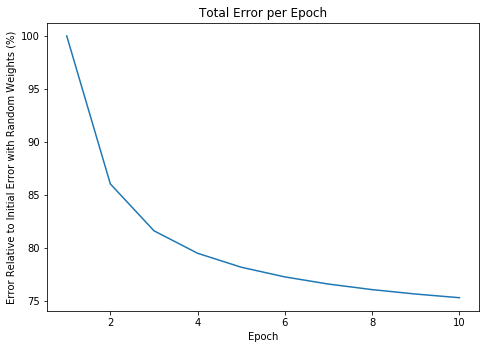

In [53]:
import matplotlib.pyplot as plt
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.plot(range(1, iterations+1), 100*total_error/total_error[0])
ax.set_title('Total Error per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Error Relative to Initial Error with Random Weights (%)')

Now we would like to test changing the length of our weight vectors. However, adding more weights might just make our network better at over-fitting. We need to randomly seperate our data into a training and testing set. We can even split it into multiple parts, train models on each separately, and average our result for a prediction - N Fold Cross Validation.

Let's start with shuffling the data and taking 20% as a test set.

In [56]:
new_data = np.copy(data)
np.random.shuffle(new_data) # Note this only shuffles row order, individual user_id/movie_id/rate entries are the same
test_set = new_data[0:int(len(new_data)/5)] 
training_set = new_data[int(len(new_data)/5):len(new_data)-1] 

NEXT STEPS: Retrain with 5, 10, 20 and plot as percent accuracy on test set (with rounded int right = correct, rounded int wrong = incorrect -> percent, NOT total error as above)

## N Fold Cross Validation
In addition to regularization, another method to avoid overfitting is to break our data into N parts and train models in each part. For each epoch, the averaged error of each model on the other parts is our error, and the average rating prediction of the networks can be taken as the net prediction. 

First, we break our data into five parts.

In [3]:
np.mean(np.array([1,2,False]))

1.0